## SMART-PBL：和我一起挑战「用 Python 做中文词云」

In [24]:
import wordcloud                     # 词云展示库
import jieba                         # 中文分词库
import requests                      # 网络请求库
from html.parser import HTMLParser   # 网页分析库
import re                            # 正则表达式库
import collections                   # 数据容器库
import numpy as np                   # 数据处理库
import matplotlib.pyplot as plt      # 图像展示库
from PIL import Image                # 图像处理库

# Jupyter Notebook
# Anaconda

In [25]:
cell_size = 10 #pixels
ms = 30 # rows and columns

#### 2.3 - 生成词云的代码

**第一步：抓取一个网页中的所有数据**

In [26]:
# 冬奥会新闻
url = 'http://www.beijing.gov.cn/ywdt/gzdt/202009/t20200928_2101234.html'
# 这里需要掌握一些 HTTP 协议的知识，浏览器软件在打开网页的时候都会发送这些信息给服务器
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) \
                          AppleWebKit/537.36 (KHTML, like Gecko) \
                          Chrome/50.0.2661.102 Safari/537.36'}
result = requests.get(url, headers=headers)
html = ''
if (result.status_code == requests.codes.ok):
    if 'ISO-8859-1' == result.encoding.upper():
        html = result.text.encode('ISO-8859-1')
        html = html.decode('UTF-8')
    else:
        html = result.content.decode(encoding=result.encoding, errors='ignore')

# 看看抓取的结果
print('网页长度：{0} 字节'.format(len(html)))
print('抓取网页中的数据片段 1：')
print('------------------------------')
print(html[0: 1000])
print('抓取网页中的数据片段 2：')
print('------------------------------')
print(html[12000: 13000])

网页长度：29626 字节
抓取网页中的数据片段 1：
------------------------------
<!DOCTYPE html>
<html>
<head>
<meta charset="utf-8">
	<title>场馆建设完成 制冰工作启动 亚洲最大冰上中心“8块冰”10月底亮相_工作动态_首都之窗_北京市人民政府门户网站</title>
	<meta name="viewport" content="width=device-width, initial-scale=1.0">
    <meta http-equiv="X-UA-Compatible" content="IE=9; IE=8; IE=7; IE=EDGE"> 
    <meta name="keywords" content="冰场;冰球;;8块冰;训练基地;冰层;冰壶;灯光;水泥混凝土;冰上项目;训练场">
    <meta name="description" content="近日，位于延庆区的北京市冰上项目训练基地冰场已经启动制冰，预计10月底，8个冰场将全部完成制冰。未来，这里将为国家队运动员备战北京冬奥会、冬残奥会提供训练场地。这是9月27日从延庆区体育局获悉的。">
    <meta name="SiteName" content="首都之窗_北京市人民政府门户网站">
    <meta name="SiteDomain" content="www.beijing.gov.cn">
    <meta name="SiteIDCode" content="1100000088">
    <meta name="ColumnName" content="工作动态">
    <meta name="ColumnType" content="工作动态">
    <meta name="ArticleTitle" content="场馆建设完成 制冰工作启动 亚洲最大冰上中心“8块冰”10月底亮相">
    <meta name="PubDate" content="2020-09-28 09:44">
    <meta name="ContentSource" content="​北京日报">
    <meta name="applicabl

如果你还记得一点点线性代数的知识的话，这是一个 15 x 15 的矩阵～

**第二步：清洗网页中的数据，去掉没有用的标签，提取有意义的文本数据**

In [27]:
# 做一个简单的 HTML 分析器，来提取 HTML 标签中的中文信息
# 理解这个分析器的工作原理，可以想象一个简单的情况，对于 <p>我</p><p>们</p> 这样一个简单的 HTML 是如何工作的
class MyHTMLParser(HTMLParser):
    title = ''
    tag_list = []
    data = ''
    
    def handle_starttag(self, tag, attrs):
        self.tag_list.append(tag)
        # print("发现了一个标签的开始", tag)

    def handle_endtag(self, tag):
        self.tag_list.pop()
        # print("Encountered an end tag :", tag)

    def handle_data(self, data):
        current_tag = ''
        if len(self.tag_list) != 0:
            current_tag = self.tag_list[len(self.tag_list) - 1]

        if current_tag == 'title':
            self.title = data
            
        if current_tag == 'p':
            self.data = self.data + data

# 创建 HTML 分析器
parser = MyHTMLParser()
# 对原始的 HTML 数据进行分析和清洗
parser.feed(html)
text_in_html = parser.data

# 看看清洗的结果
print('HTML 清洗的结果：')
print(text_in_html[0: 1000], '...')

HTML 清洗的结果：
场馆建设完成 制冰工作启动 亚洲最大冰上中心“8块冰”10月底亮相
                        
                　　原标题：场馆建设完成，制冰工作启动 亚洲最大冰上中心“8块冰”下月底亮相　　近日，位于延庆区的北京市冰上项目训练基地冰场已经启动制冰，预计10月底，8个冰场将全部完成制冰。未来，这里将为国家队运动员备战北京冬奥会、冬残奥会提供训练场地。这是9月27日从延庆区体育局获悉的。　　在延庆城中心、美丽的妫水河畔，一座由半圆形“冰球”和圆角方形“冰壶”组合而成的“天圆地方”冰上场馆群拔地而起，这就是北京市冰上项目训练基地，亚洲单体最大的综合性冰上中心。训练基地内共包含冰球、冰壶、花样滑冰和短道速滑4个项目共计8个冰场。眼下，场馆整体建设已经完成，配套设施建设正在有序推进，7号冰场作为首个制冰冰场，正在进行底冰制作。　　7号冰场是一个面积为1000平方米的冰壶训练场，步入冰场，冷气迎面扑来。温度计显示，冰场内的温度只有10摄氏度。冰场上已经有了一层薄薄的冰水混合物，工作人员正在进行第二次底冰制作。“要在水泥混凝土面上制作冰面，不是一件容易的事儿。要先除尘、除湿，确保整体环境达标，同时严格把控水的质量，确保冰层符合要求。”制冰机电技术负责人范兵说。　　经过特殊处理后的清水顺着管道被注入冰场，混凝土面层下埋藏着冷冻设备，可以让清水凝固成底冰。“为保证底冰平整、结实，一般会进行4次浇冰，底冰成型后，在上面打上冰漆，制作冰层。冰层完成后，整个制冰工序才算结束，而这样一套流程大约需要7到10天。”范兵说。　　在1号冰场内，水泥混凝土面已经铺设完毕，工作人员正在除尘和调试灯光。与7号冰场单纯用作训练不同，1号冰场不仅是冰球训练场，还是设有观众席的比赛场地。冰球运动场馆对灯光的要求比较严格。灯光既不能太过刺眼，也不能在冰面上打出运动员的影子，影响比赛。因此，冰球场馆的灯光调试工作格外重要。　　1号冰场的屋顶上，70台白色场地灯绕场一周，24台彩灯集中在看台顶部。工作人员正在操作台操控着按键，屋顶上的灯按指令明灭、运动、变色。“70台场地灯已经基本调试好，并将位置固定了下来。将来比赛颁奖或赛前表演时，这24台彩灯可以在冰场上打出彩色3D图案，营造欢快气氛。”现场施工负责人范启文说。　　目前，基地“8块冰”的制冰工作正在

**第三步：对网页中的文本数据进行分词**

In [28]:
# 去掉文本中的标点符号

# 定义正则表达式匹配模式，如果是英文的化就不要去掉空格了，英文去掉空格英文就没办法分词喽^^
pattern = re.compile(u'\s*|\t|\n|\.|-|:|;|\)|\(|\?|"'
                     u'|，|。|；|“|”|、|？|！|《|》|：|（|）') 
# 将符合模式的字符去除
string_data = re.sub(pattern, '', text_in_html) 

# 看看清洗了标点符号以后的结果
print('HTML 清洗了标点符号后的结果：')
print(string_data[0: 1000], '...')

HTML 清洗了标点符号后的结果：
场馆建设完成制冰工作启动亚洲最大冰上中心8块冰10月底亮相原标题场馆建设完成制冰工作启动亚洲最大冰上中心8块冰下月底亮相近日位于延庆区的北京市冰上项目训练基地冰场已经启动制冰预计10月底8个冰场将全部完成制冰未来这里将为国家队运动员备战北京冬奥会冬残奥会提供训练场地这是9月27日从延庆区体育局获悉的在延庆城中心美丽的妫水河畔一座由半圆形冰球和圆角方形冰壶组合而成的天圆地方冰上场馆群拔地而起这就是北京市冰上项目训练基地亚洲单体最大的综合性冰上中心训练基地内共包含冰球冰壶花样滑冰和短道速滑4个项目共计8个冰场眼下场馆整体建设已经完成配套设施建设正在有序推进7号冰场作为首个制冰冰场正在进行底冰制作7号冰场是一个面积为1000平方米的冰壶训练场步入冰场冷气迎面扑来温度计显示冰场内的温度只有10摄氏度冰场上已经有了一层薄薄的冰水混合物工作人员正在进行第二次底冰制作要在水泥混凝土面上制作冰面不是一件容易的事儿要先除尘除湿确保整体环境达标同时严格把控水的质量确保冰层符合要求制冰机电技术负责人范兵说经过特殊处理后的清水顺着管道被注入冰场混凝土面层下埋藏着冷冻设备可以让清水凝固成底冰为保证底冰平整结实一般会进行4次浇冰底冰成型后在上面打上冰漆制作冰层冰层完成后整个制冰工序才算结束而这样一套流程大约需要7到10天范兵说在1号冰场内水泥混凝土面已经铺设完毕工作人员正在除尘和调试灯光与7号冰场单纯用作训练不同1号冰场不仅是冰球训练场还是设有观众席的比赛场地冰球运动场馆对灯光的要求比较严格灯光既不能太过刺眼也不能在冰面上打出运动员的影子影响比赛因此冰球场馆的灯光调试工作格外重要1号冰场的屋顶上70台白色场地灯绕场一周24台彩灯集中在看台顶部工作人员正在操作台操控着按键屋顶上的灯按指令明灭运动变色70台场地灯已经基本调试好并将位置固定了下来将来比赛颁奖或赛前表演时这24台彩灯可以在冰场上打出彩色3D图案营造欢快气氛现场施工负责人范启文说目前基地8块冰的制冰工作正在加速进行中近百名工作人员在场馆内同时施工在保证工艺质量的情况下加快施工进度预计到10月底整个基地内8个冰场的制冰工作将全部完成北京住总集团冰训基地项目部相关负责人说张宏民李瑶您访问的链接即将离开首都之窗门户网站是否继续 ...


In [29]:
# 下面，我们对去掉标点符号后的文本进行分词
# cut_all=False 是精确模式分词，否则像'共和国'这样的词会被分成'共和国'，'共和' 和 '国'
seg_list_exact = jieba.cut(string_data, cut_all = False) 
all_words = list(seg_list_exact)

print('看看分词的结果：')
print(all_words[0:100])

看看分词的结果：
['场馆', '建设', '完成', '制冰', '工作', '启动', '亚洲', '最大', '冰上', '中心', '8', '块冰', '10', '月底', '亮相', '原', '标题', '场馆', '建设', '完成', '制冰', '工作', '启动', '亚洲', '最大', '冰上', '中心', '8', '块冰', '下', '月底', '亮相', '近日', '位于', '延庆', '区', '的', '北京市', '冰上', '项目', '训练', '基地', '冰场', '已经', '启动', '制冰', '预计', '10', '月底', '8', '个', '冰场', '将', '全部', '完成', '制冰', '未来', '这里', '将', '为', '国家队', '运动员', '备战', '北京', '冬奥会', '冬', '残奥会', '提供', '训练场地', '这是', '9', '月', '27', '日', '从', '延庆', '区', '体育局', '获悉', '的', '在', '延庆', '城中心', '美丽', '的', '妫', '水', '河畔', '一座', '由', '半圆形', '冰球', '和', '圆角', '方形', '冰壶', '组合而成', '的', '天圆地方', '冰上']


看到这个分词的结果是不是还挺兴奋的，我们已经把一片长文分词了，接下来只需要数一下每种词有几个就可以开始生成词云了。
但是仔细一看你，还是有个问题，有很多词，例如'的'、'是'、'有'这种字会影响词云的效果。
下面我们把这些字也去掉。

In [38]:
# 自定义去除词库
remove_words = [u'的', u'，', u'和', u'是', u'中', u'在', u'了', u'各', u'有',
                u'对', u'等', u'能', u'都', u'。', u'要', u'、', u'我',
                u'对于', u'随着', u'通常', u'如果', u'我们', u'需要', u' ', '不'] 

clean_word_list = []
# 循环读出每个分词
for word in all_words:        
    # 如果不在去除词库中
    if word not in remove_words:  
        # 分词追加到最终列表
        clean_word_list.append(word)

# 对分词做词频统计，数一数每个不同的词都出现了多少次，一行代码搞定
word_counts = collections.Counter(clean_word_list)          

# 看看统计的结果如何
print('看看去除无用词以后的结果：')
# 获取前10最高频的词
word_counts_top20 = word_counts.most_common(20) 
# 输出检查
print(word_counts_top20)

看看去除无用词以后的结果：
[('冰场', 16), ('制冰', 8), ('场馆', 6), ('完成', 6), ('冰上', 6), ('8', 6), ('基地', 6), ('正在', 6), ('号', 6), ('工作', 5), ('10', 5), ('已经', 5), ('冰球', 5), ('上', 5), ('建设', 4), ('月底', 4), ('训练', 4), ('个', 4), ('将', 4), ('7', 4)]


In [39]:
word_counts

Counter({'场馆': 6,
         '建设': 4,
         '完成': 6,
         '制冰': 8,
         '工作': 5,
         '启动': 3,
         '亚洲': 3,
         '最大': 3,
         '冰上': 6,
         '中心': 3,
         '8': 6,
         '块冰': 3,
         '10': 5,
         '月底': 4,
         '亮相': 2,
         '原': 1,
         '标题': 1,
         '下': 3,
         '近日': 1,
         '位于': 1,
         '延庆': 3,
         '区': 2,
         '北京市': 2,
         '项目': 3,
         '训练': 4,
         '基地': 6,
         '冰场': 16,
         '已经': 5,
         '预计': 2,
         '个': 4,
         '将': 4,
         '全部': 2,
         '未来': 1,
         '这里': 1,
         '为': 2,
         '国家队': 1,
         '运动员': 2,
         '备战': 1,
         '北京': 1,
         '冬奥会': 1,
         '冬': 1,
         '残奥会': 1,
         '提供': 1,
         '训练场地': 1,
         '这是': 1,
         '9': 1,
         '月': 1,
         '27': 1,
         '日': 1,
         '从': 1,
         '体育局': 1,
         '获悉': 1,
         '城中心': 1,
         '美丽': 1,
         '妫': 1,
         '水':

**第四步：加载词云的轮廓图片，生成云图并保存**

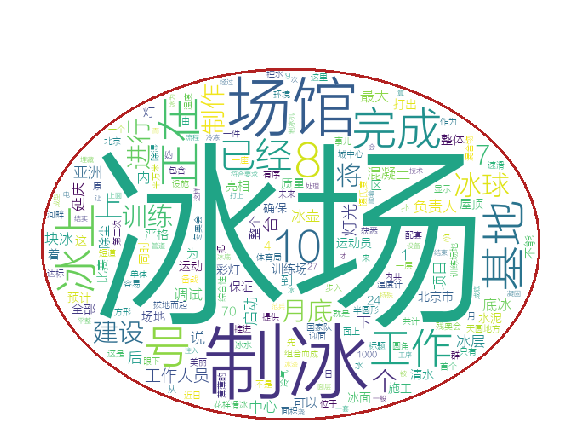

In [43]:
# 词频展示，定义词频背景
wc_mask = np.array(Image.open('design/tuoyuan.jpg'))

wc = wordcloud.WordCloud(
    # 设置字体格式
    font_path='design/buzz_cloud_font.ttf', 
    # 设置背景图
    mask=wc_mask, 
    # 最多显示词数
    max_words=200,
    # 字体最大值
    max_font_size=320,
    # 整体背景色
    background_color='White',
    # 词云的边框大小
    contour_width=2,
    # 词云的边框颜色
    contour_color='Firebrick'
    
)

# 从字典生成词云
wc.generate_from_frequencies(word_counts) 
# 从背景图建立颜色方案
image_colors = wordcloud.ImageColorGenerator(wc_mask)
# 显示词云
plt.figure(figsize=[10, 10])
plt.imshow(wc)                                       
plt.axis('off')                                      
plt.show()
# 在自己的操作系统里弹窗显示词云图
wc.to_image().show()

# 把生成的词云图存储在自己的硬盘里
wc.to_image().save('result/y.png')

下面我们换一个背景图看看好不好^^

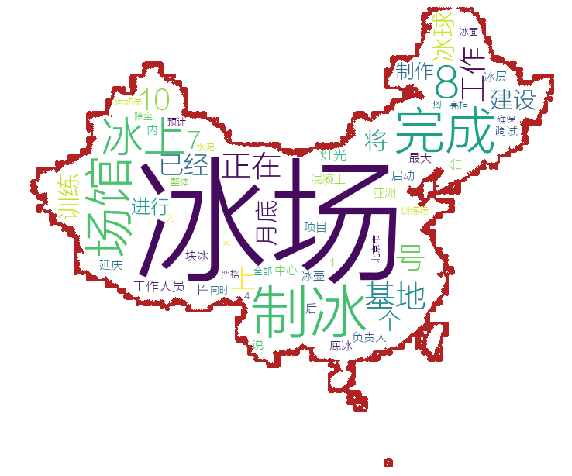

In [44]:
# 词频展示，定义词频背景
wc_mask = np.array(Image.open('design/map.jpg'))

wc = wordcloud.WordCloud(
    # 设置字体格式
    font_path='design/buzz_cloud_font.ttf', 
    # 设置背景图
    mask=wc_mask, 
    # 最多显示词数
    max_words=60,
    # 字体最大值
    max_font_size=320,
    # 整体背景色
    background_color='White',
    # 词云的边框大小
    contour_width=2,
    # 词云的边框颜色
    contour_color='Firebrick'
)

# 从字典生成词云
wc.generate_from_frequencies(word_counts) 
# 从背景图建立颜色方案
image_colors = wordcloud.ImageColorGenerator(wc_mask)
# 显示词云
plt.figure(figsize=[10, 10])
plt.imshow(wc)                                       
plt.axis('off')                                      
plt.show() 
# 在自己的操作系统里弹窗显示词云图
# wc.to_image().show()

# 把生成的词云图存储在自己的硬盘里
wc.to_image().save('result/china_map.png')

### 3 - 思考题

---

- 自己试着换一个背景图吧，换一个形状显示词云，发挥你的想象力！
- 词云图里的词好多，能不能少一点呢？我有密集恐惧症，不想看这么多。
- 这个字体不好看，换个字体？